## DSI-06 Homework 6: ANSWERS
From Chapter 7, found on page 327 of ISLP

*This question uses the variables `dis` (the weighted mean of distances to five Boston employment centers) and `nox` (nitrogen oxides concentration in parts per 10 million) from the `Boston` data. We will treat `dis` as the predictor and `nox` as the response.*

In [54]:
# Import libraries and specific objects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import random
import patsy 
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from statsmodels.stats.anova import anova_lm

# Load Default data
Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


(a)  Use the `poly()` function to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.

In [55]:
# Create polynomial features using numpy
Boston['dis_poly'] = np.power(Boston['dis'], 3)

# Fit a cubic polynomial regression
poly_fit = sm.OLS.from_formula('nox ~ dis_poly', data=Boston).fit()

# Print regression output
print(poly_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     210.5
Date:                Sun, 26 Nov 2023   Prob (F-statistic):           4.16e-40
Time:                        15:48:47   Log-Likelihood:                 461.36
No. Observations:                 506   AIC:                            -918.7
Df Residuals:                     504   BIC:                            -910.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5913      0.005    117.948      0.0

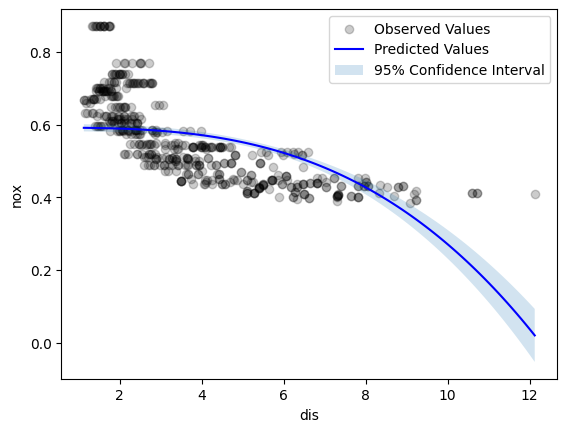

In [56]:
# Generate a range of 'dis' values for predictions
dis_range = np.linspace(min(Boston['dis']), max(Boston['dis']), 100)
dis_poly_range = np.power(dis_range, 3)

# Predict response and standard errors
pred = poly_fit.get_prediction({'dis_poly': dis_poly_range})
conf_int = pred.conf_int()

# Create a dataframe with predictions and confidence intervals
predictions = pd.DataFrame({
    'DIS': dis_range,
    'NOX': pred.predicted_mean,
    'upper': conf_int[:, 1],
    'lower': conf_int[:, 0]
})

# Plot the observed values, predicted values, and confidence intervals
plt.scatter(Boston['dis'], Boston['nox'], color='black', alpha=0.2, label='Observed Values')
plt.plot(predictions['DIS'], predictions['NOX'], color='blue', linewidth=1.5, label='Predicted Values')
plt.fill_between(predictions['DIS'], predictions['lower'], predictions['upper'], alpha=0.2, label='95% Confidence Interval')
plt.xlabel('dis')
plt.ylabel('nox')
plt.legend()
plt.show()

(b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

Residual sum of squares for 1 degrees: 0.00361975850945371
Residual sum of squares for 2 degrees: 0.003614215492795284
Residual sum of squares for 3 degrees: 0.003637635266662808
Residual sum of squares for 4 degrees: 0.0036436679293959757
Residual sum of squares for 5 degrees: 0.0036442439864925714
Residual sum of squares for 6 degrees: 0.003663320509040575
Residual sum of squares for 7 degrees: 0.0036908511023790126
Residual sum of squares for 8 degrees: 0.0037054007430970645
Residual sum of squares for 9 degrees: 0.003705594390341445
Residual sum of squares for 10 degrees: 0.0037039614476885294


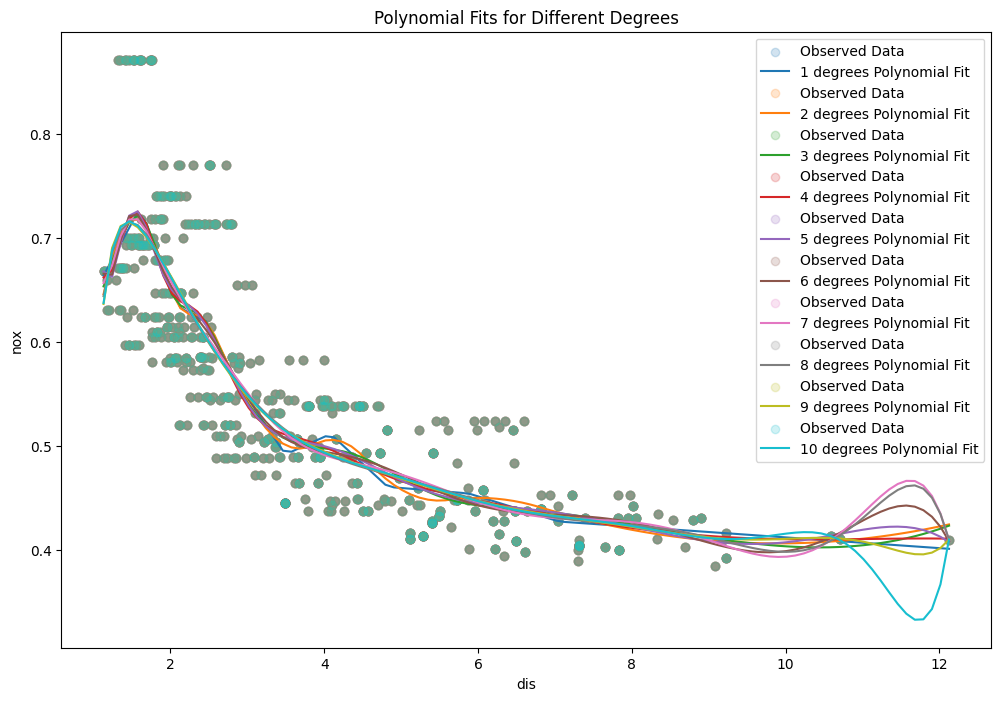

In [57]:
# Set the range of polynomial degrees
range_poly = range(1, 11)

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate over polynomial degrees
for degrees in range_poly:
    # Create polynomial features using patsy
    formula = f'nox ~ bs(dis, degree={degrees}, include_intercept=False, df=11)'
    y, X = patsy.dmatrices(formula, Boston, return_type='dataframe')

    # Fit a polynomial regression
    poly_fit = sm.OLS(y, X).fit()

    # Generate a range of 'dis' values for predictions
    dis_range = np.linspace(min(Boston['dis']), max(Boston['dis']), 100)
    X_range = patsy.build_design_matrices([X.design_info], {'dis': dis_range})[0]

    # Predict response
    nox_pred = poly_fit.predict(X_range)

    # Plot the data and polynomial fit
    plt.scatter(Boston['dis'], Boston['nox'], alpha=0.2, label='Observed Data')
    plt.plot(dis_range, nox_pred, label=f'{degrees} degrees Polynomial Fit')

    # Calculate and print residual sum of squares
    errors = np.sum(np.square(poly_fit.resid)) / (len(Boston) - len(poly_fit.params))
    print(f"Residual sum of squares for {degrees} degrees: {errors}")

# Add labels and legend to the plot
plt.xlabel('dis')
plt.ylabel('nox')
plt.legend()
plt.title('Polynomial Fits for Different Degrees')
plt.show()

(c)  Perform cross-validation or another approach (hint: *anova*) to select the optimal degree for the polynomial, and explain your results.

In [58]:
np.random.seed(16)
range_poly = np.arange(1, 11)
cv_error = np.empty(10)

for degrees in range_poly:
    poly_model = make_pipeline(PolynomialFeatures(degrees), LinearRegression())
    cv_error[degrees - 1] = -np.mean(cross_val_score(poly_model, Boston[['dis']], Boston['nox'], scoring='neg_mean_squared_error', cv=10))

best_degree = np.argmin(cv_error) + 1
print(f"The best polynomial degree is: {best_degree}")

The best polynomial degree is: 3


Alternatively, we can use an Anova to compare the 10 degrees

In [59]:
degrees = np.arange(1, 11)

# Fit polynomial models and store them in a list
poly_fits = [sm.OLS(Boston['nox'], sm.add_constant(PolynomialFeatures(degree).fit_transform(Boston[['dis']])))
             .fit() for degree in degrees]

# Perform ANOVA
anova_table = sm.stats.anova_lm(*poly_fits)
print(anova_table)

   df_resid       ssr  df_diff   ss_diff           F        Pr(>F)
0     504.0  2.768563      0.0       NaN         NaN           NaN
1     503.0  2.035262      1.0  0.733301  198.116860  3.558589e-38
2     502.0  1.934107      1.0  0.101155   27.329219  2.522104e-07
3     501.0  1.932981      1.0  0.001125    0.304045  5.816033e-01
4     500.0  1.915290      1.0  0.017691    4.779699  2.926006e-02
5     499.0  1.878257      1.0  0.037033   10.005161  1.656138e-03
6     498.0  1.849484      1.0  0.028774    7.773823  5.503632e-03
7     497.0  1.835630      1.0  0.013854    3.742933  5.359844e-02
8     496.0  1.833331      1.0  0.002299    0.621093  4.310180e-01
9     495.0  1.832171      1.0  0.001160    0.313312  5.759079e-01


The p-values from the ANOVA indicate that we can reject the null hypothesis when compare model 1 to
model 2 and model 2 to model 3. This means that both the linear and quadratic models are not sufficient to
explain the data. The p-value for the comparison of model 3 and 4 is not significant so we could say that
a 3rd degree polynomial is sufficient to explain the data over the 4th. In this case, 3rd degree polynomial
would be sufficient to explain the data, similar to what was found using CV.

(d) Use the `bs()` function to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

In [60]:
# Fit a cubic B-spline with 4 degrees of freedom
spline_formula = 'nox ~ bs(dis, df=4, degree=3, include_intercept=True) - 1'
y, X = patsy.dmatrices(spline_formula, Boston, return_type='dataframe')

# Fit the spline model
spline_fit = sm.OLS(y, X).fit()

# Print summary
print(spline_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Sun, 26 Nov 2023   Prob (F-statistic):          2.71e-136
Time:                        15:49:01   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

(e)  Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

Summary of Model fit for 3 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.791
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              634.5
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                   1.67e-170
Time:                        15:50:33   Log-Likelihood:                         -34.519
No. Observations:                 506   AIC:                                      75.04
Df Residuals:                     503   BIC:                                      87.72
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

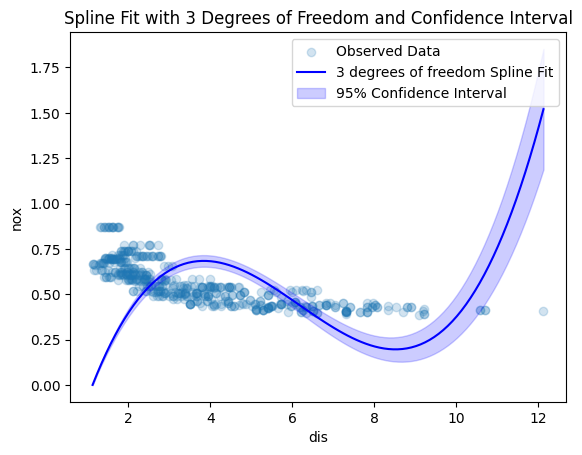

Summary of Model fit for 4 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              1627.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                   9.40e-286
Time:                        15:50:33   Log-Likelihood:                          236.46
No. Observations:                 506   AIC:                                     -464.9
Df Residuals:                     502   BIC:                                     -448.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

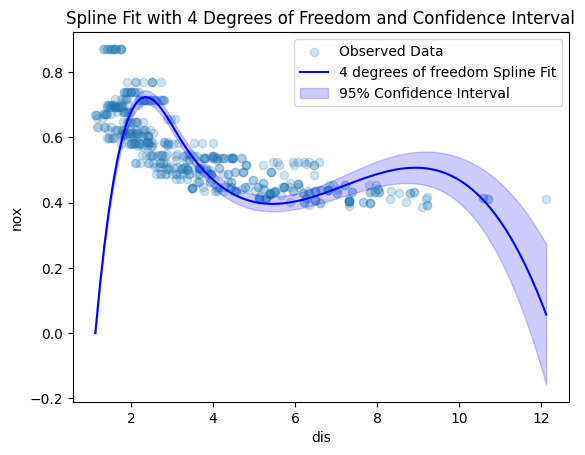

Summary of Model fit for 5 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2604.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          403.19
No. Observations:                 506   AIC:                                     -796.4
Df Residuals:                     501   BIC:                                     -775.2
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

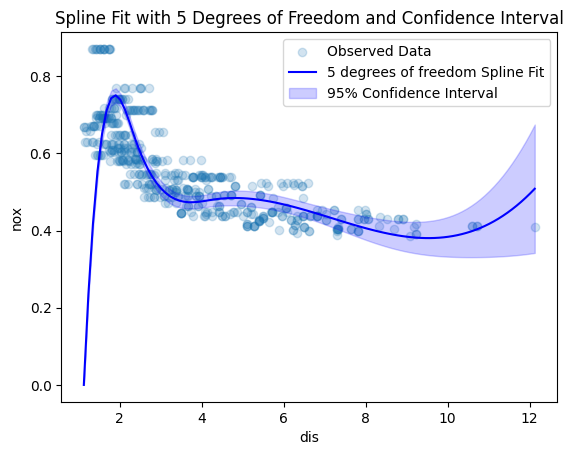

Summary of Model fit for 6 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              2827.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          468.41
No. Observations:                 506   AIC:                                     -924.8
Df Residuals:                     500   BIC:                                     -899.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

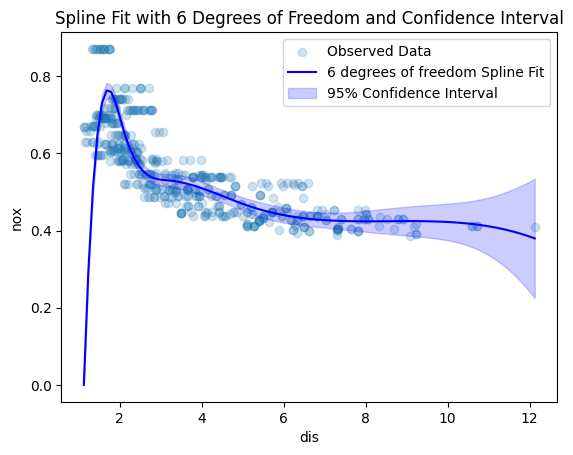

Summary of Model fit for 7 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              2797.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          504.18
No. Observations:                 506   AIC:                                     -994.4
Df Residuals:                     499   BIC:                                     -964.8
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

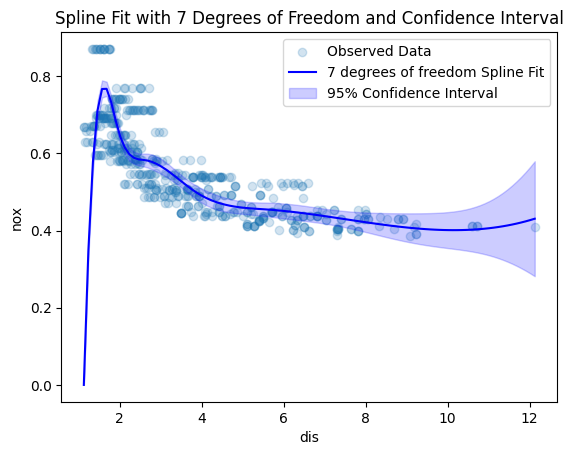

Summary of Model fit for 8 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              2678.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          526.92
No. Observations:                 506   AIC:                                     -1038.
Df Residuals:                     498   BIC:                                     -1004.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

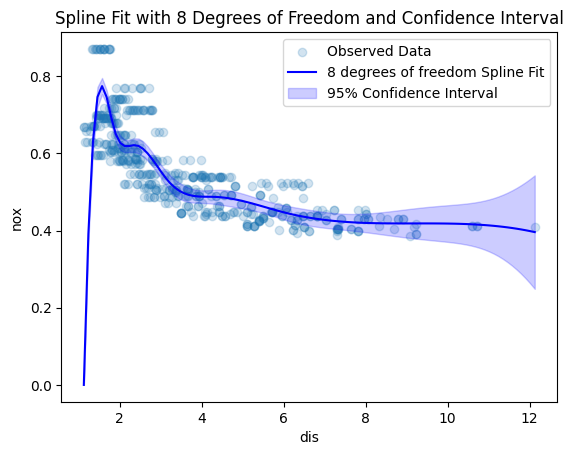

Summary of Model fit for 9 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              2466.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          536.18
No. Observations:                 506   AIC:                                     -1054.
Df Residuals:                     497   BIC:                                     -1016.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P

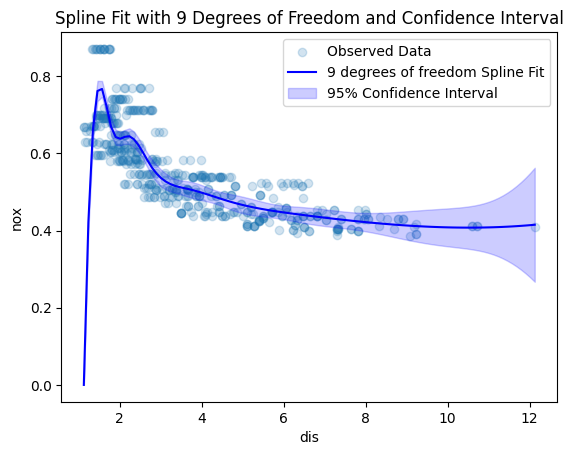

Summary of Model fit for 10 degrees of freedom spline regression
                                 OLS Regression Results                                
Dep. Variable:                    nox   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              2255.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:50:34   Log-Likelihood:                          540.58
No. Observations:                 506   AIC:                                     -1061.
Df Residuals:                     496   BIC:                                     -1019.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t     

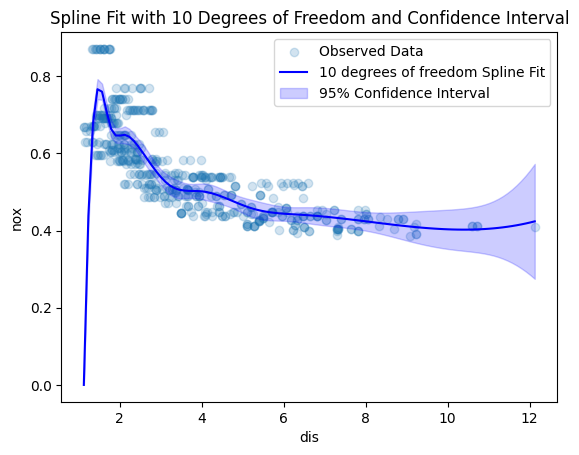

In [61]:
# Set the range of spline degrees
range_splines = range(3, 11)

for spline_degree in range_splines:
    # Fit a spline model
    formula = f'nox ~ bs(dis, df={spline_degree}) - 1'
    spline_fit = sm.OLS.from_formula(formula, data=Boston).fit()

    # Generate a range of 'dis' values for predictions
    dis_range = np.linspace(min(Boston['dis']), max(Boston['dis']), 100)
    X_range = pd.DataFrame({'dis': dis_range})
    
    # Predict response
    pred_results = spline_fit.get_prediction(X_range)
    pred = pred_results.predicted_mean
    conf_int = pred_results.conf_int()

    # Calculate and print residual sum of squares
    errors = np.sum(np.square(spline_fit.resid)) / (len(Boston) - len(spline_fit.params))
    print(f"Summary of Model fit for {spline_degree} degrees of freedom spline regression")
    print(spline_fit.summary())
    print(f"Residual sum of squares: {errors}")
    print("--------------------------------------------------------------")

    # Plot the data and spline fit with confidence interval
    plt.scatter(Boston['dis'], Boston['nox'], alpha=0.2, label='Observed Data')
    plt.plot(dis_range, pred, label=f'{spline_degree} degrees of freedom Spline Fit', color='blue')
    plt.fill_between(dis_range, conf_int[:, 0], conf_int[:, 1], color='blue', alpha=0.2, label='95% Confidence Interval')

    # Add labels and legend to the plot
    plt.xlabel('dis')
    plt.ylabel('nox')
    plt.legend()
    plt.title(f'Spline Fit with {spline_degree} Degrees of Freedom and Confidence Interval')
    plt.show()

(f)   Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

*Use Anova to compare models*

In [62]:
# Fit spline models
spline_fit3 = sm.OLS.from_formula('nox ~ bs(dis, df=3) - 1', data=Boston).fit()
spline_fit4 = sm.OLS.from_formula('nox ~ bs(dis, df=4) - 1', data=Boston).fit()
spline_fit5 = sm.OLS.from_formula('nox ~ bs(dis, df=5) - 1', data=Boston).fit()
spline_fit6 = sm.OLS.from_formula('nox ~ bs(dis, df=6) - 1', data=Boston).fit()
spline_fit7 = sm.OLS.from_formula('nox ~ bs(dis, df=7) - 1', data=Boston).fit()
spline_fit8 = sm.OLS.from_formula('nox ~ bs(dis, df=8) - 1', data=Boston).fit()
spline_fit9 = sm.OLS.from_formula('nox ~ bs(dis, df=9) - 1', data=Boston).fit()
spline_fit10 = sm.OLS.from_formula('nox ~ bs(dis, df=10) - 1', data=Boston).fit()

# Perform ANOVA
anova_results = anova_lm(spline_fit3, spline_fit4, spline_fit5, spline_fit6, spline_fit7, spline_fit8, spline_fit9, spline_fit10)
print(anova_results)

   df_resid        ssr  df_diff    ss_diff            F         Pr(>F)
0     503.0  33.957136      0.0        NaN          NaN            NaN
1     502.0  11.635073      1.0  22.322063  3165.815118  6.216742e-219
2     501.0   6.019657      1.0   5.615416   796.403523  1.384454e-105
3     500.0   4.651670      1.0   1.367986   194.013925   1.687559e-37
4     499.0   4.038404      1.0   0.613267    86.976237   3.565316e-19
5     498.0   3.691307      1.0   0.347096    49.226759   7.484271e-12
6     497.0   3.558646      1.0   0.132662    18.814690   1.745317e-05
7     496.0   3.497281      1.0   0.061365     8.703072   3.326892e-03
